In [48]:
mErde, mOzean, RErde, mMond, rMondBahn, TMondBahn, G = 5.9721986*10**24, 0.0014*10**24, 6.3675*10**6, 7.3459*10**22, 3.836*10**8, 27.32166140*24*3600, 6.67430*10**(-11)
TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from scipy.constants import pi
import scipy
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.ivp import OdeResult # :) https://github.com/scipy/scipy/blob/main/scipy/integrate/_ivp/ivp.py
from matplotlib.animation import FuncAnimation
from IPython.display import Image #to display animations

# Beautiful plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"

# Useful StackPosts
# https://stackoverflow.com/questions/59634279/solve-ivp-error-required-step-size-is-less-than-spacing-between-numbers

# Executing everything all the time takes too long
fastExecution = True

In [49]:
def baryzentrum(m1, m2, r): return r*m2/(m1+m2) # TODO Remove, redundant

def iv_stable_orbit_4body():
    '''Initial conditions for the Earth-Moon-Tides system in a stable orbit'''
    # Each of the tides gets half of the oceans mass 
    mass = [mErde, mMond, mOzean/2, mOzean/2]
    
    # We want the center of mass to be at the origin, the tides count towards the earth,
    # but weigh so little that the center of doesn't really change
    abstand_baryzentrum_erde = baryzentrum(mErde + mOzean, mMond, rMondBahn)
    x0_Erde = [-abstand_baryzentrum_erde, 0]
    x0_Mond = [rMondBahn-abstand_baryzentrum_erde, 0]

    # We choose the starting velocities such that the center of mass is at rest
    vy0_Erde = 2*pi*abstand_baryzentrum_erde/TMondBahn
    vy0_Mond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

    # The moon starts in positive, the earth in negative y-direction
    v0_Erde = [0, -vy0_Erde]
    v0_Mond = [0, vy0_Mond]

    # The tides start on the same axis as the moon on opposite sides of the earth
    phi_1 = 0
    phi_2 = pi

    # The tides start with the same velocity as the moon
    omega_1 = 2*pi/TMondBahn
    omega_2 = 2*pi/TMondBahn

    return [x0_Erde, x0_Mond, phi_1, phi_2, v0_Erde, v0_Mond, omega_1, omega_2, mass]

def eq_motion_4body(t, state, mass):
    '''This function calculates the derivatives of the state vector for a specific 4 body problem (Earth-Moon with tidal forces) to be passed to solve_ivp. \\
    state: state vector is given by [x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2].
    mass: list of the masses of the two bodys. e.g. [m_E, m_M, m1, m2]'''
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2 = state
    m_E, m_M, m_1, m_2 = mass

    # Variables as defined in the explanation above
    mu_x = m_E + m_1*np.cos(phi_1)**2 + m_2*np.cos(phi_2)**2
    mu_y = m_E + m_1*np.sin(phi_1)**2 + m_2*np.sin(phi_2)**2
    a = (G*m_M*m_E)/((x_M - x_E)**2 + (y_M - y_E)**2)**(3/2)
    b = m_1*np.sin(phi_1)*np.cos(phi_1) + m_2*np.sin(phi_2)*np.cos(phi_2)
    x_1 = x_E + RErde*np.cos(phi_1)
    y_1 = y_E + RErde*np.sin(phi_1)
    x_2 = x_E + RErde*np.cos(phi_2)
    y_2 = y_E + RErde*np.sin(phi_2)
    c1 = m_1*RErde*omega_1**2 + (G*m_M*m_1*((x_M - x_1)*np.cos(phi_1) + (y_M - y_1)*np.sin(phi_1)))/((x_M - x_1)**2 + (y_M - y_1)**2)**(3/2)
    c2 = m_2*RErde*omgea_2**2 + (G*m_M*m_2*((x_M - x_2)*np.cos(phi_2) + (y_M - y_2)*np.sin(phi_2)))/((x_M - x_2)**2 + (y_M - y_2)**2)**(3/2)

    # The earth's acceleration:    
    ax_E = 1/(mu_x - b**2/mu_y) * (a*(x_M - x_E) -b/mu_y*(a*(y_M - y_E) + c1*np.sin(phi_1) + c2*np.sin(phi_2)) + c1*np.cos(phi_1) + c2*np.cos(phi_2))
    ay_E = 1/mu_y*(a*(y_M - y_E) - b*ax_E + c1*np.sin(phi_1) + c2*np.sin(phi_2))

    # The moon's acceleration:
    ax_M = G*((m_E*(x_E - x_M))/((x_E - x_M)**2 + (y_E - y_M)**2)**(3/2) + (m_1*(x_1 - x_M))/((x_1 - x_M)**2 + (y_1 - y_M)**2)**(3/2) + (m_2*(x_2 - x_M))/((x_2 - x_M)**2 + (y_2 - y_M)**2)**(3/2))
    ay_M = G*((m_E*(y_E - y_M))/((x_E - x_M)**2 + (y_E - y_M)**2)**(3/2) + (m_1*(y_1 - y_M))/((x_1 - x_M)**2 + (y_1 - y_M)**2)**(3/2) + (m_2*(y_2 - y_M))/((x_2 - x_M)**2 + (y_2 - y_M)**2)**(3/2))

    return [vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2, ax_E, ay_E, ax_M, ay_M, 0, 0]

In [54]:
k = 2*10**(-12)

def iv_stable_orbit_4body_friction():
    '''Initial conditions for the Earth-Moon-Tides system in a stable orbit'''
    x0_Erde, x0_Mond, phi_1, phi_2, v0_Erde, v0_Mond, omega_1, omega_2, mass = iv_stable_orbit_4body()
    phi0_E = 0 # The starting point of the earth's rotation is unconsequentially defined as 0
    omega0_E = 2*pi / TErdRotation # Angular velocity of the earth
    return [x0_Erde, x0_Mond, phi_1, phi_2, phi0_E, v0_Erde, v0_Mond, omega_1, omega_2, omega0_E, mass]

def tides_acceleration_friction(x_M, y_M, x_i, y_i, phi_i, ax_E, ay_E, omega_i, m_M):
    '''Calculates the angular acceleration of a tide, using the equation above'''
    ax_friction = k * RErde**2 * np.abs(omega_i - omega_E)* (omega_i - omega_E) * np.cos(phi_i)
    ay_friction = -k * RErde**2 * np.abs(omega_i - omega_E)* (omega_i - omega_E) * np.sin(phi_i)
    part_a = G*m_M* ((y_M - y_i)*np.cos(phi_i) - (x_M - x_i)*np.sin(phi_i)) / ((x_M - x_i)**2 + (y_M - y_i)**2)**(3/2)
    part_b = (RErde*omega_i**2 - (ax_E*np.cos(phi_i) + ay_E*np.sin(phi_i)))
    ax_i = -part_a*np.sin(phi_i) - part_b*np.cos(phi_i) + ax_friction
    ay_i =  part_a*np.cos(phi_i) - part_b*np.sin(phi_i) + ay_friction

    alpha_i = (-(ax_i - ax_E)*np.sin(phi_i) + (ay_i - ay_E)*np.cos(phi_i))/RErde
    return alpha_i

def eq_motion_4body_friction(t, state, mass):
    x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2, omega_E = state
    x_1, y_1, x_2, y_2 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1), x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)
    m_E, m_M, m_1, m_2 = mass
    
    # Reuse the equations of motion from the 4-body problem for the earth and the moon:
    _, _, _, _, _, _, ax_E, ay_E, ax_M, ay_M, _, _ = eq_motion_4body(t, np.array([x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2]), mass)

    # Tides angular acceleration:
    alpha_1 = tides_acceleration_friction(x_M, y_M, x_1, y_1, phi_1, ax_E, ay_E, omega_1, m_M)
    alpha_2 = tides_acceleration_friction(x_M, y_M, x_2, y_2, phi_2, ax_E, ay_E, omega_2, m_M)

    # The earth's angular acceleration:
    alpha_E = (5*k*RErde)/(2*m_E) * (m_1*np.abs(omega_1 - omega_E)*(omega_1 - omega_E) + m_2*np.abs(omega_2 - omega_E)*(omega_2 - omega_E))

    return[vx_E, vy_E, vx_M, vy_M, omega_1, omega_2, omega_E, ax_E, ay_E, ax_M, ay_M, alpha_1, alpha_2, alpha_E]

def four_body_problem_friction(pos_body_1: list, pos_body_2: list, phi_1: float, phi_2: float, phi_E:float, vel_body_1: list, vel_body_2: list, omega_1: float, omega_2: float, omega_E: float, mass: list, t_max: float, steps=1, method='RK45', t_start=0):
    solution = solve_ivp(fun=eq_motion_4body_friction, t_span=[t_start, t_max], y0=[*pos_body_1, *pos_body_2, phi_1, phi_2, phi_E, *vel_body_1, *vel_body_2, omega_1, omega_2, omega_E], args=(mass,), rtol=1e-6, atol=1e-6)
    x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2, omega_E = solution.y
    return [solution.t, x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, omega_1, omega_2, omega_E]

# 100*365*24*3600 <- 100 Jahre
t, x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, omega_1, omega_2, omega_E = four_body_problem_friction(*iv_stable_orbit_4body_friction(), 100*365*24*3600)

In [62]:
# TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
# tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

# The change in the angular velocity
angular_velocity_change = (omega_E[0] - omega_E[-1])

# w = 2*pi/T -> T = 2*pi/w
rotation_period_at_start = (2*pi/omega_E[0])
rotation_period_at_end = (2*pi/omega_E[-1])
print(f'rotation_period_at_start: {rotation_period_at_start}, rotation_period_at_end: {rotation_period_at_end}')
print(f'rotation_period_at_start [h]: {rotation_period_at_start/3600}, rotation_period_at_end [h]: {rotation_period_at_end/3600}')

print(f'tau_lit: {tau}, tau_calc: {rotation_period_at_end - rotation_period_at_start}')

rotation_period_at_start: 86164.10000000002, rotation_period_at_end: 86301.15118568535
rotation_period_at_start [h]: 23.93447222222223, rotation_period_at_end [h]: 23.972541996023708
tau_lit: 0.0021, tau_calc: 137.05118568532635


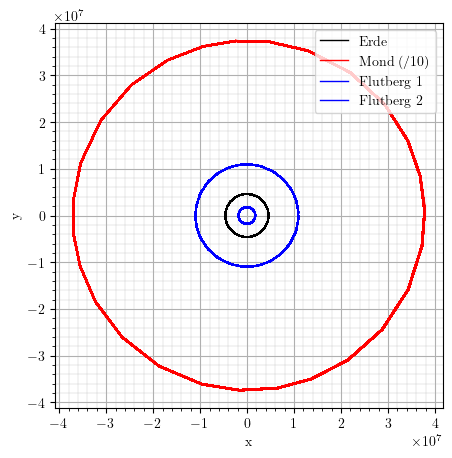

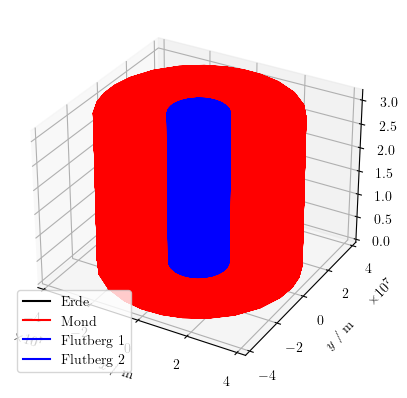

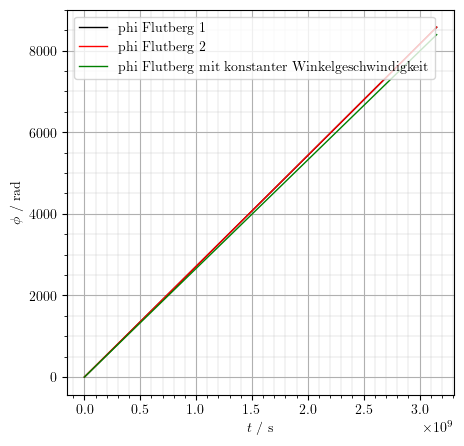

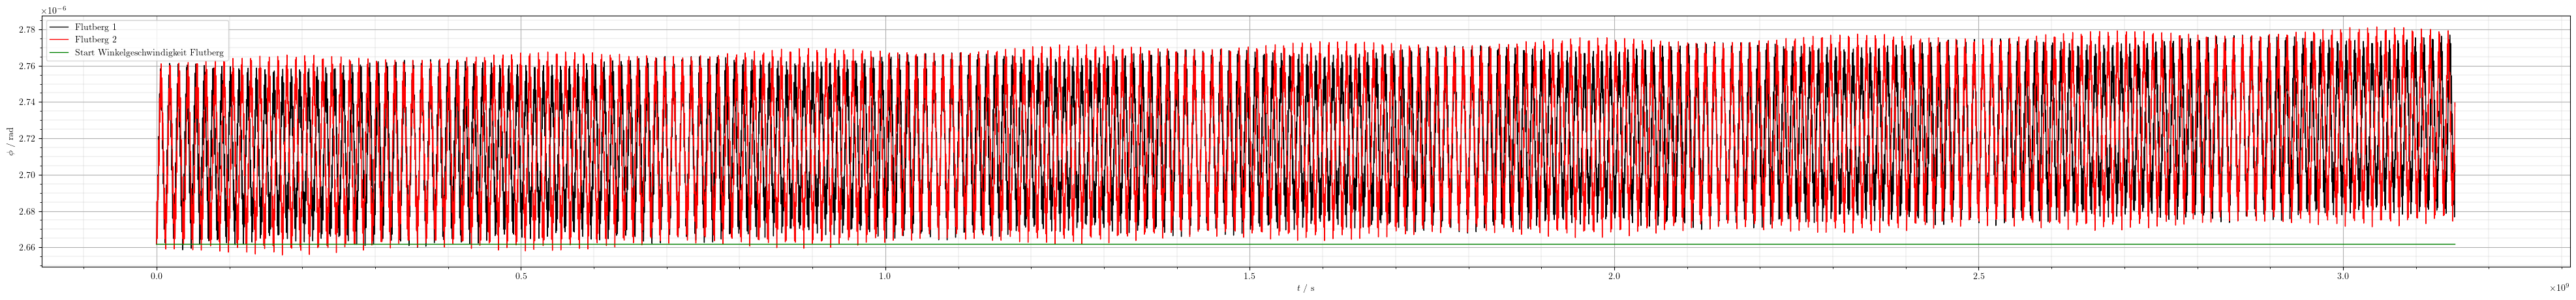

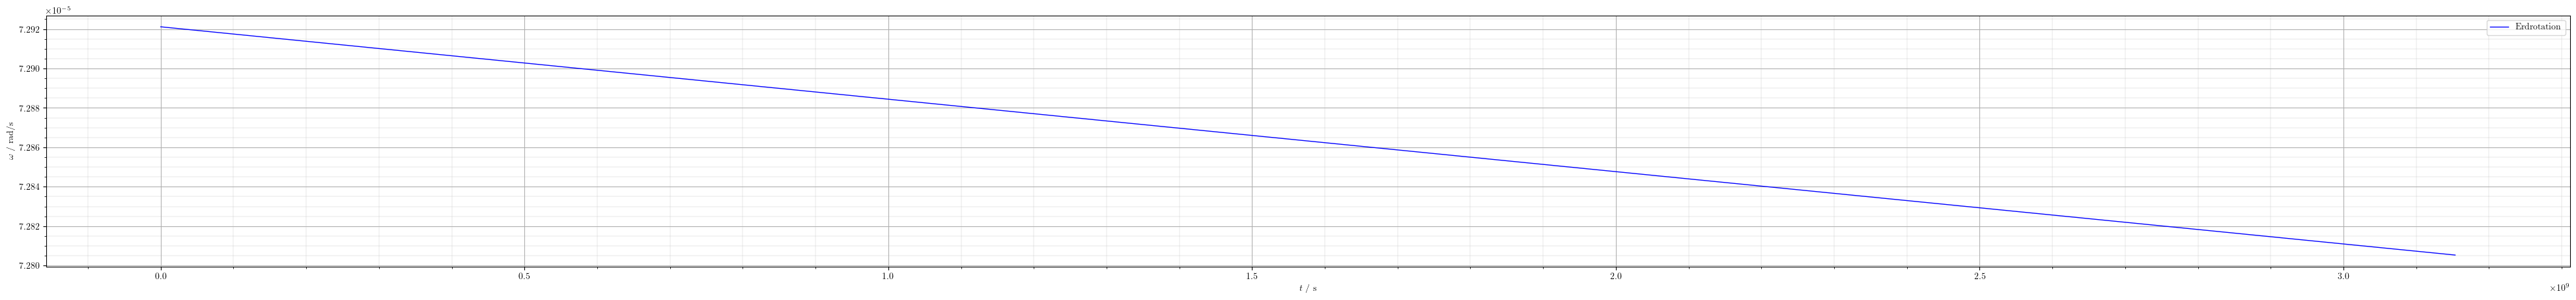

tau_lit: 0.0021, tau_change: 0.10144340701066962


In [58]:
x_1, y_1 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1)
x_2, y_2 = x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)

plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("x")
plt.ylabel("y")

plt.plot(x_E, y_E, 'k', linewidth=1, label='Erde')
plt.plot(x_M/10, y_M/10, 'r', linewidth=1, label='Mond (/10)')
plt.plot(x_1, y_1, 'b', linewidth=1, label='Flutberg 1')
plt.plot(x_2, y_2, 'b', linewidth=1, label='Flutberg 2')

plt.legend()
plt.show()
plt.close()

# Plot a 3d phase space diagram
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot(x_E, y_E, t, 'k', label='Erde')
ax.plot(x_M/10, y_M/10, t, 'r', label='Mond')
ax.plot(x_1, y_1, t, 'b', label='Flutberg 1')
ax.plot(x_2, y_2, t, 'b', label='Flutberg 2')
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

# Plot the angles of the tides over time
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\phi$ / rad")

plt.plot(t, phi_1 , 'k', linewidth=1, label='phi Flutberg 1')
plt.plot(t, phi_2, 'r', linewidth=1, label='phi Flutberg 2')
# plt.plot(t, phi_E, 'b', linewidth=1, label='Äquator')
plt.plot(t, np.multiply(t, 2*pi/TMondBahn), 'g', linewidth=1, label='phi Flutberg mit konstanter Winkelgeschwindigkeit')
plt.legend()
plt.show()
plt.close()

# Plot the anglevelocities of the tides over time
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(50, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\phi$ / rad")

plt.plot(t, omega_1 , 'k', linewidth=1, label='Flutberg 1')
plt.plot(t, omega_2, 'r', linewidth=1, label='Flutberg 2')
# plt.plot(t, omega_E, 'b', linewidth=1, label='Äquator')
plt.plot(t, [2*pi/TMondBahn]*np.shape(t)[0], 'g', linewidth=1, label='Start Winkelgeschwindigkeit Flutberg')

plt.legend()
plt.show()
plt.close()

# Plot the anglular velocitiy of the earth over time
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(50, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\omega$ / rad/s")

plt.plot(t, omega_E, 'b', linewidth=1, label='Erdrotation')

plt.legend()
plt.show()
plt.close()

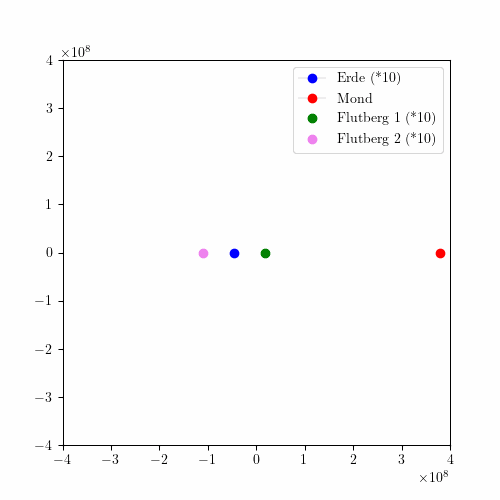

In [52]:
# Remove every 2nd element of the array to reduce the amount of data
count = 1
while(x_E.size > 300):
    t, x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, omega_1, omega_2, omega_E = t[::2], x_E[::2], y_E[::2], x_M[::2], y_M[::2], phi_1[::2], phi_2[::2], phi_E[::2], omega_1[::2], omega_2[::2], omega_E[::2]
    count += 1

x_1, y_1 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1)
x_2, y_2 = x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)

# Animation of the four body problem #
fig = plt.figure(figsize=(5, 5)) # Square figure, so the circles are actually circles
ax = plt.axes(xlim=(-4e8, 4e8), ylim=(-4e8, 4e8))
earth_line, = ax.plot([], [], marker='o', lw=0.1, color='blue', label='Erde (*10)')
moon_line, = ax.plot([], [], marker='o', lw=0.1, color='red', label='Mond')
tide_1_line, = ax.plot([], [], marker='o', lw=0.1, color='green', label='Flutberg 1 (*10)')
tide_2_line, = ax.plot([], [], marker='o', lw=0.1, color='violet', label='Flutberg 2 (*10)')
ax.legend()

def animate(i):
    earth_line.set_data([x_E[i]*10], [y_E[i]*10])
    moon_line.set_data([x_M[i]], [y_M[i]])
    tide_1_line.set_data([x_1[i]*10], [y_1[i]*10])
    tide_2_line.set_data([x_2[i]*10], [y_2[i]*10])
    return earth_line, moon_line

anim = FuncAnimation(fig, animate, init_func=None, frames=t.shape[0], interval=30, blit=True)
anim.save('Erde_Mond_Flutberge_Spin.gif', writer='pillow')
plt.close()

display(Image(data=open('Erde_Mond_Flutberge_Friction.gif','rb').read(), format='png'))